In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/ANNDL_Challenge_1/

Mounted at /gdrive
/gdrive/My Drive/ANNDL_Challenge_1


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
import utils

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load dataset

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)

(68528, 7)


### Preprocessing

In [ ]:
# Normalize both features and labels
x_min = dataset.min()
x_max = dataset.max()

x_train_raw = (dataset - x_min) / (x_max - x_min)

In [ ]:
window = 200
stride = 4
telescope = 864
batch_size = 32
epochs = 100
patience = 10
factor = 0.5
min_lr = 1e-5
lstm_neurons = [32, 64]
lstm_layers = len(lstm_neurons)

def get_model_name(neurons):
    neurons_str = ""
    for i in range(0, len(neurons)):
        neurons_str += str(neurons[i])
        if (len(neurons) > i + 1):
            neurons_str += '-'
    name_model = neurons_str + "n"
    return name_model

models_folder = 'baseline_'
model_version = get_model_name(lstm_neurons) + 'lstm_' + str(window) + 'w_' + str(stride) + 's' + '_sigmoid_dropout'
path_to_model = os.path.join(os.path.join('.', models_folder), model_version)
path_to_model

'./baseline_/32-64nlstm_10w_1s_sigmoid_dropout'

In [ ]:
x_train, y_train = utils.build_sequences(x_train_raw, 
                                         dataset.columns, 
                                         window, 
                                         stride, 
                                         telescope)
x_train.shape, y_train.shape

((67656, 10, 7), (67656, 864, 7))

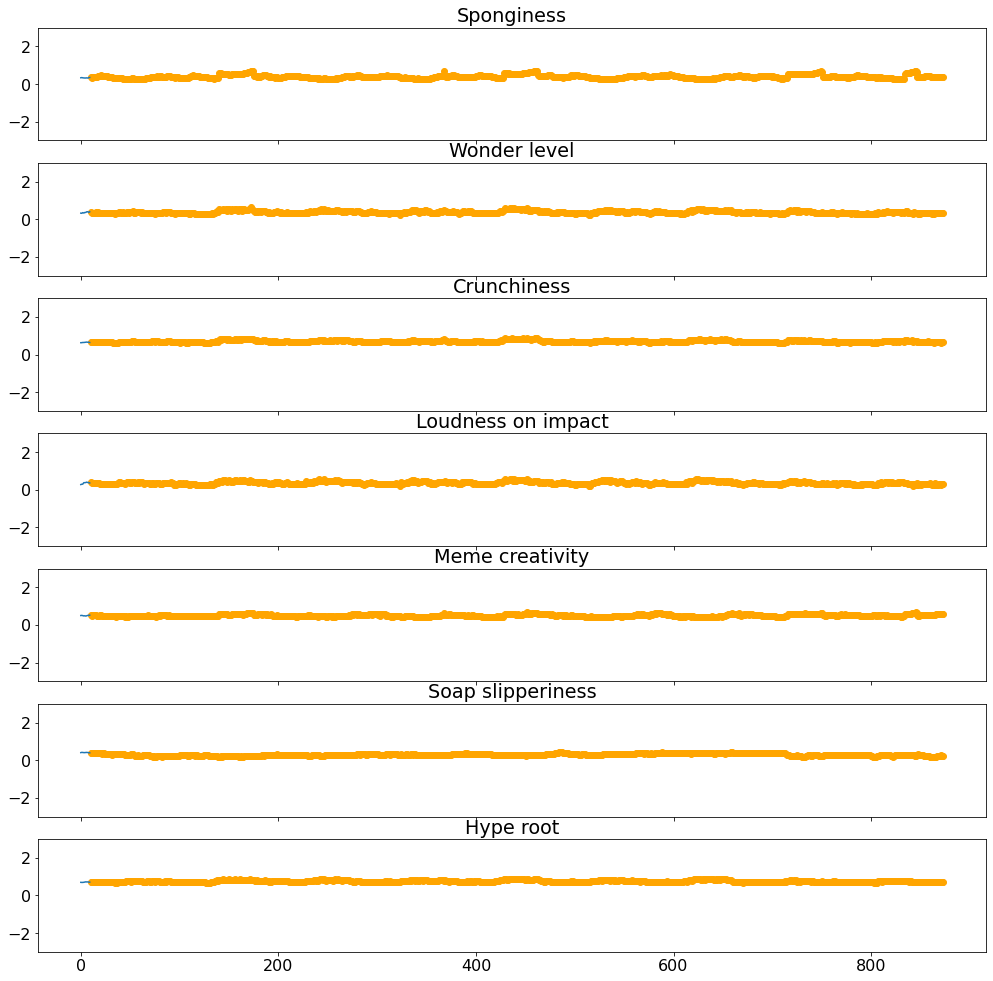

In [ ]:
utils.inspect_multivariate(x_train, y_train, dataset.columns, telescope)

In [ ]:
def build_LSTM_model(input_shape, output_shape, lstm_neurons):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    is_first = True

    for neurons in lstm_neurons:
        if is_first:
            lstms = tfkl.LSTM(neurons, return_sequences=True)(input_layer)
            is_first = False
        else:
            lstms = tfkl.LSTM(neurons, return_sequences=True)(lstms)
        
    lstms = tfkl.GlobalAveragePooling1D()(lstms)

    # In order to predict the next values for more than one sensor,
    # we can use a Dense layer with a number given by telescope*num_sensors,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_sensors]
    dense = tfkl.Dense(output_shape[-1] * output_shape[-2], activation='sigmoid')(lstms)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=utils.metrics())

    # Return the model
    return model

model = build_LSTM_model(x_train.shape[1:], y_train.shape[1:], lstm_neurons)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10, 7)]           0         
                                                                 
 dropout (Dropout)           (None, 10, 7)             0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            5120      
                                                                 
 dropout_1 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            24832     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                             

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.3,
    callbacks = utils.callbacks(which_monitor='val_loss', 
                                maxOrMin='min', 
                                patience=patience, 
                                factor=factor, 
                                min_lr=min_lr, 
                                model_version=model_version, 
                                models_folder=models_folder)
).history

Epoch 1/100
1479/1480 [============================>.] - ETA: 0s - loss: 0.0157 - mae: 0.0929 - mape: 12741.0215 - mse: 0.0157 - msle: 0.0072 - rmse: 0.1252

1480/1480 [==============================] - 74s 47ms/step - loss: 0.0157 - mae: 0.0929 - mape: 12737.5391 - mse: 0.0157 - msle: 0.0072 - rmse: 0.1252 - val_loss: 0.0173 - val_mae: 0.0992 - val_mape: 8758.9521 - val_mse: 0.0173 - val_msle: 0.0081 - val_rmse: 0.1317 - lr: 0.0010
Epoch 2/100
1480/1480 [==============================] - ETA: 0s - loss: 0.0125 - mae: 0.0824 - mape: 10946.2754 - mse: 0.0125 - msle: 0.0057 - rmse: 0.1119

1480/1480 [==============================] - 55s 37ms/step - loss: 0.0125 - mae: 0.0824 - mape: 10946.2754 - mse: 0.0125 - msle: 0.0057 - rmse: 0.1119 - val_loss: 0.0174 - val_mae: 0.0988 - val_mape: 8788.8340 - val_mse: 0.0174 - val_msle: 0.0080 - val_rmse: 0.1320 - lr: 0.0010
Epoch 3/100
1478/1480 [============================>.] - ETA: 0s - loss: 0.0117 - mae: 0.0791 - mape: 10566.9746 - mse: 0.0117 - msle: 0.0053 - rmse: 0.1079

1480/1480 [==============================] - 57s 38ms/step - loss: 0.0117 - mae: 0.0791 - mape: 10567.3047 - mse: 0.0117 - msle: 0.0053 - rmse: 0.1080 - val_loss: 0.0213 - val_mae: 0.1109 - val_mape: 8941.8438 - val_mse: 0.0213 - val_msle: 0.0097 - val_rmse: 0.1459 - lr: 0.0010
Epoch 4/100
1480/1480 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0763 - mape: 10272.1426 - mse: 0.0109 - msle: 0.0050 - rmse: 0.1044

1480/1480 [==============================] - 59s 40ms/step - loss: 0.0109 - mae: 0.0763 - mape: 10272.1426 - mse: 0.0109 - msle: 0.0050 - rmse: 0.1044 - val_loss: 0.0253 - val_mae: 0.1214 - val_mape: 8867.6162 - val_mse: 0.0253 - val_msle: 0.0114 - val_rmse: 0.1591 - lr: 0.0010
Epoch 5/100
1479/1480 [============================>.] - ETA: 0s - loss: 0.0104 - mae: 0.0744 - mape: 10032.2744 - mse: 0.0104 - msle: 0.0048 - rmse: 0.1020

1480/1480 [==============================] - 59s 40ms/step - loss: 0.0104 - mae: 0.0744 - mape: 10027.4082 - mse: 0.0104 - msle: 0.0048 - rmse: 0.1020 - val_loss: 0.0281 - val_mae: 0.1293 - val_mape: 9084.8115 - val_mse: 0.0281 - val_msle: 0.0128 - val_rmse: 0.1676 - lr: 0.0010
Epoch 6/100
1479/1480 [============================>.] - ETA: 0s - loss: 0.0101 - mae: 0.0730 - mape: 9929.0312 - mse: 0.0101 - msle: 0.0046 - rmse: 0.1003

1480/1480 [==============================] - 59s 40ms/step - loss: 0.0101 - mae: 0.0730 - mape: 9927.1973 - mse: 0.0101 - msle: 0.0046 - rmse: 0.1003 - val_loss: 0.0282 - val_mae: 0.1304 - val_mape: 9004.9951 - val_mse: 0.0282 - val_msle: 0.0129 - val_rmse: 0.1679 - lr: 0.0010
Epoch 7/100
1480/1480 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.0717 - mape: 9792.0420 - mse: 0.0097 - msle: 0.0045 - rmse: 0.0986

1480/1480 [==============================] - 55s 37ms/step - loss: 0.0097 - mae: 0.0717 - mape: 9792.0420 - mse: 0.0097 - msle: 0.0045 - rmse: 0.0986 - val_loss: 0.0271 - val_mae: 0.1261 - val_mape: 9177.4688 - val_mse: 0.0271 - val_msle: 0.0124 - val_rmse: 0.1645 - lr: 5.0000e-04
Epoch 8/100
1480/1480 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0712 - mape: 9729.9932 - mse: 0.0096 - msle: 0.0044 - rmse: 0.0979

1480/1480 [==============================] - 59s 40ms/step - loss: 0.0096 - mae: 0.0712 - mape: 9729.9932 - mse: 0.0096 - msle: 0.0044 - rmse: 0.0979 - val_loss: 0.0302 - val_mae: 0.1336 - val_mape: 9201.4990 - val_mse: 0.0302 - val_msle: 0.0140 - val_rmse: 0.1737 - lr: 5.0000e-04
Epoch 9/100
1479/1480 [============================>.] - ETA: 0s - loss: 0.0095 - mae: 0.0706 - mape: 9690.5840 - mse: 0.0095 - msle: 0.0044 - rmse: 0.0972

1480/1480 [==============================] - 55s 37ms/step - loss: 0.0095 - mae: 0.0706 - mape: 9696.6084 - mse: 0.0095 - msle: 0.0044 - rmse: 0.0972 - val_loss: 0.0301 - val_mae: 0.1344 - val_mape: 9152.8115 - val_mse: 0.0301 - val_msle: 0.0140 - val_rmse: 0.1735 - lr: 5.0000e-04
Epoch 10/100
1480/1480 [==============================] - ETA: 0s - loss: 0.0093 - mae: 0.0702 - mape: 9667.9346 - mse: 0.0093 - msle: 0.0043 - rmse: 0.0966

1480/1480 [==============================] - 59s 40ms/step - loss: 0.0093 - mae: 0.0702 - mape: 9667.9346 - mse: 0.0093 - msle: 0.0043 - rmse: 0.0966 - val_loss: 0.0291 - val_mae: 0.1308 - val_mape: 9049.5371 - val_mse: 0.0291 - val_msle: 0.0136 - val_rmse: 0.1706 - lr: 5.0000e-04
Epoch 11/100
1480/1480 [==============================] - ETA: 0s - loss: 0.0092 - mae: 0.0698 - mape: 9607.1113 - mse: 0.0092 - msle: 0.0043 - rmse: 0.0961

1480/1480 [==============================] - 55s 37ms/step - loss: 0.0092 - mae: 0.0698 - mape: 9607.1113 - mse: 0.0092 - msle: 0.0043 - rmse: 0.0961 - val_loss: 0.0289 - val_mae: 0.1307 - val_mape: 9025.6543 - val_mse: 0.0289 - val_msle: 0.0135 - val_rmse: 0.1700 - lr: 5.0000e-04


In [ ]:
model.save(path_to_model)

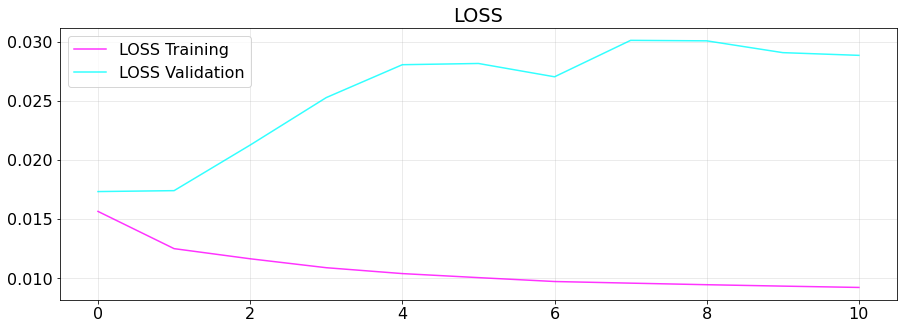

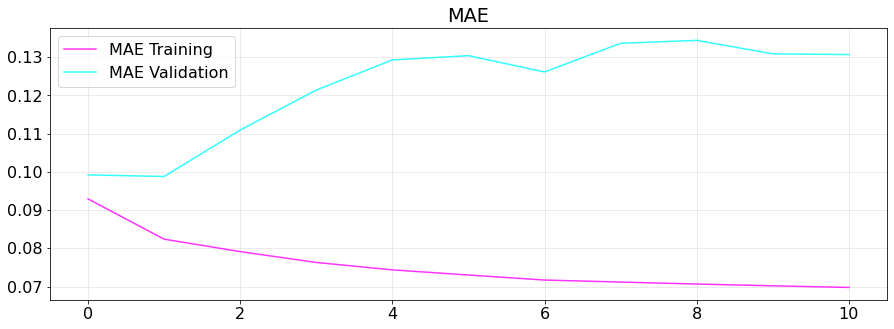

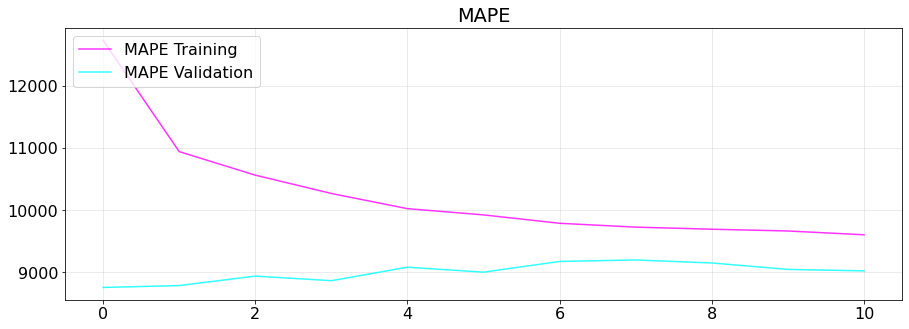

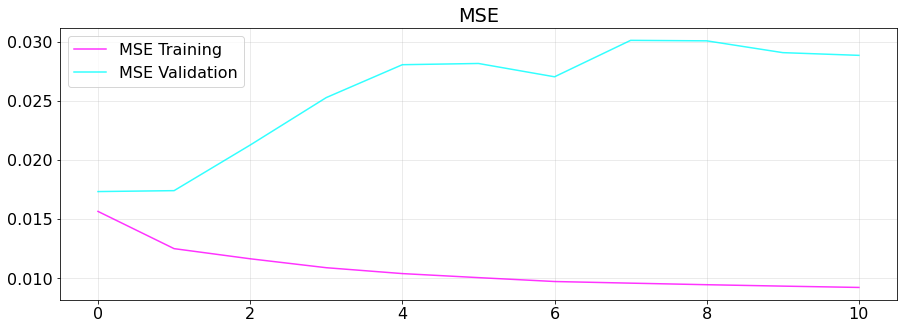

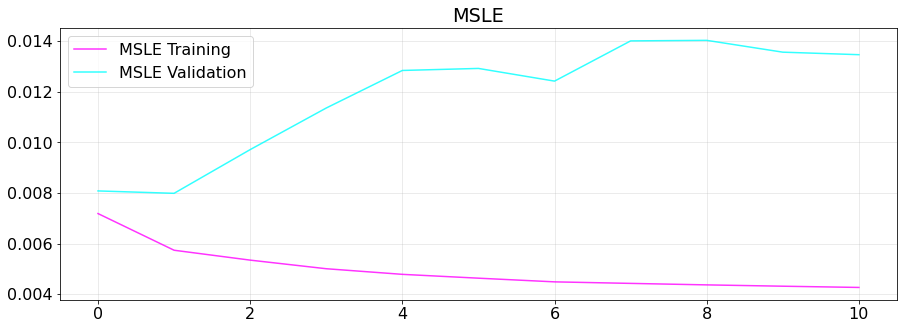

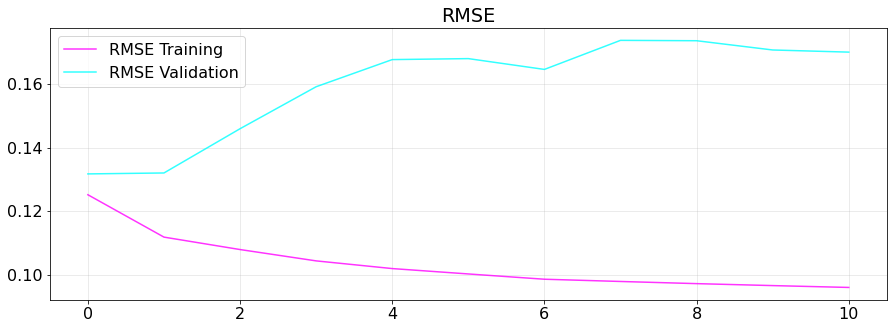

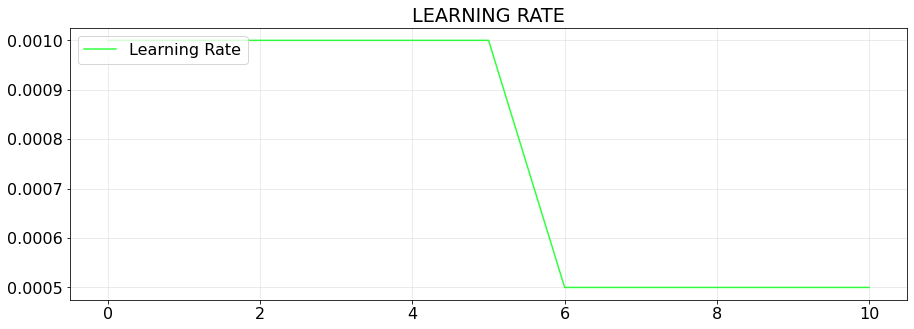

In [ ]:
utils.plot_and_save(history, model_version, models_folder)

In [ ]:
# to load old history from file
# old_history = np.load(os.path.join(path_to_model, 'history.npy'), allow_pickle='TRUE').item()

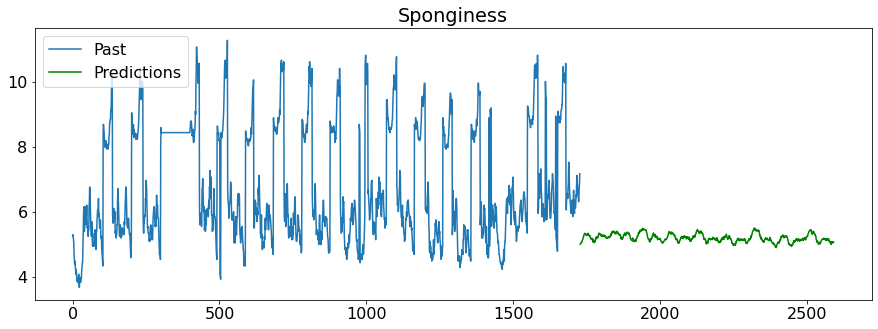

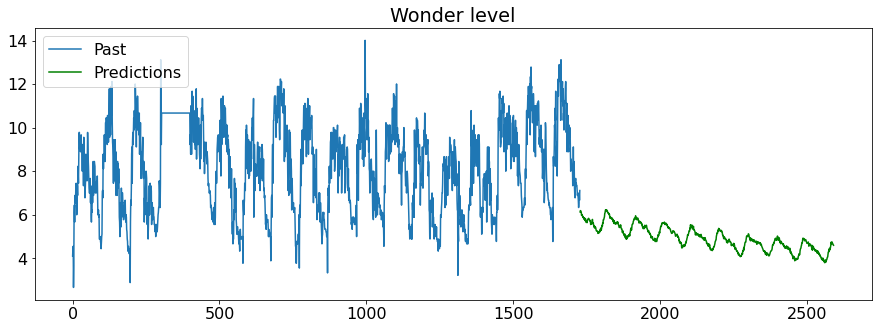

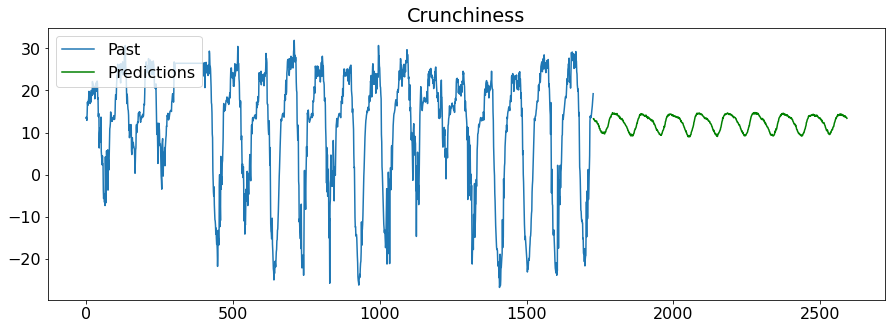

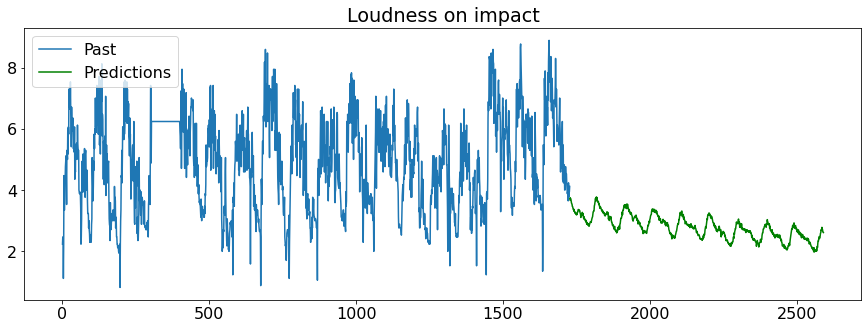

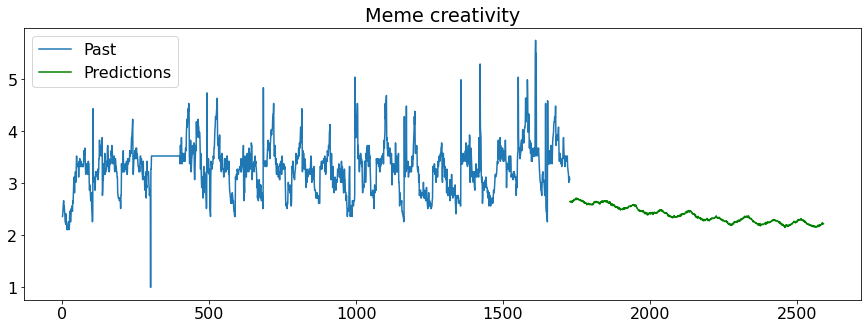

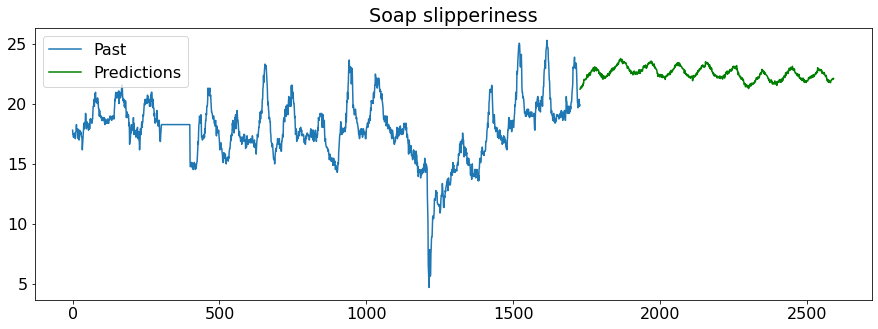

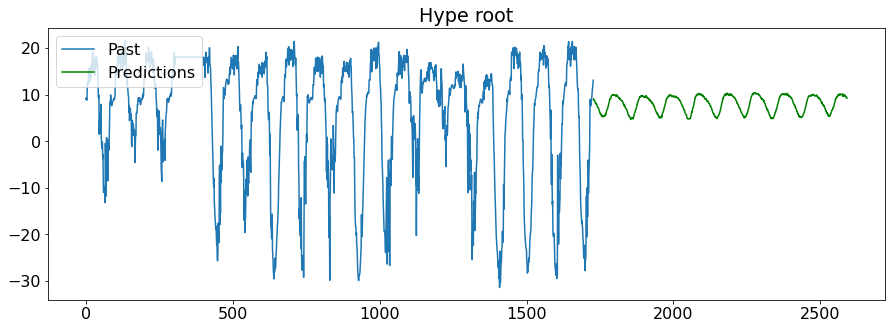

In [ ]:
model = tfk.models.load_model(path_to_model)
out = utils.processing_and_prediction(dataset=dataset, window=window, telescope=telescope, model=model)
utils.inspect_multivariate_prediction(dataset.to_numpy(), out, dataset.columns, telescope, models_folder, model_version)

In [ ]:
model_version, models_folder

('32-64nlstm_10w_1s_sigmoid_dropout', 'baseline_')